## STEP 1:Load Raw Data

In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv('Dataset_Uber Traffic.csv')

# Preview
df.head()
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

## STEP 2: Clean the Data

In [4]:
# Drop duplicates
df = df.drop_duplicates()

In [5]:
# Check missing values
df.isnull().sum()

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

In [6]:
# Fill missing values in 'Vehicles' column with median value
df['Vehicles'] = df['Vehicles'].fillna(df['Vehicles'].median())

In [7]:
df.dtypes


DateTime    object
Junction     int64
Vehicles     int64
ID           int64
dtype: object

In [8]:
# Convert DateTime column to proper datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24904\4236684332.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DateTime'] = pd.to_datetime(df['DateTime'])


## STEP 3: Aggregate traffic data
✅ STEP 1: Load & Prepare Time Columns

In [88]:
import pandas as pd

# Load the CSV
merged = pd.merge(df, weather_merged, left_on='DateTime', right_on='datetime', how='left')



In [90]:
# Convert to datetime
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%y %H:%M')



# Extract useful time components
df['Date'] = df['DateTime'].dt.date
df['Hour'] = df['DateTime'].dt.hour



✅ STEP 2: Group by Junction, Date, and Hour


In [93]:
# Group to get hourly traffic volume per junction
hourly_df = df.groupby(['Junction', 'Date', 'Hour'])['Vehicles'].sum().reset_index()


In [95]:
#Quick test to check formats:
print(df['DateTime'].head(10))

0       2015-01-11 00:00:00
14592   2015-01-11 00:00:00
29184   2015-01-11 00:00:00
1       2015-01-11 01:00:00
14593   2015-01-11 01:00:00
29185   2015-01-11 01:00:00
14594   2015-01-11 02:00:00
29186   2015-01-11 02:00:00
2       2015-01-11 02:00:00
14595   2015-01-11 03:00:00
Name: DateTime, dtype: datetime64[ns]


## STEP 4: Preprocess the data

In [98]:
# I'll go with Standardization (z-score), as it's more robust for time series with outliers.
from sklearn.preprocessing import StandardScaler

# Assume you already have hourly_df from the last step
scaler = StandardScaler()

# Only scale the 'Vehicles' column
hourly_df['Vehicles_scaled'] = scaler.fit_transform(hourly_df[['Vehicles']])


In [100]:
# Aiming to view the scaled vehicle data in a clean tabular format
from tabulate import tabulate
print(tabulate(hourly_df[['Junction', 'Date', 'Hour', 'Vehicles', 'Vehicles_scaled']].head(), headers='keys', tablefmt='github'))


|    |   Junction | Date       |   Hour |   Vehicles |   Vehicles_scaled |
|----|------------|------------|--------|------------|-------------------|
|  0 |          1 | 2015-01-11 |      0 |  0.0782123 |         -0.375489 |
|  1 |          1 | 2015-01-11 |      1 |  0.0670391 |         -0.471875 |
|  2 |          1 | 2015-01-11 |      2 |  0.0502793 |         -0.616454 |
|  3 |          1 | 2015-01-11 |      3 |  0.0335196 |         -0.761034 |
|  4 |          1 | 2015-01-11 |      4 |  0.0446927 |         -0.664648 |


In [102]:
# save the Preprocessed Data
hourly_df.to_csv("Preprocessed_Traffic_Data.csv", index=False)


## Feature Engineering and Selection

✅ STEP 1: Create New Time-Based Features

In [106]:
hourly_df['DateTime'] = pd.to_datetime(hourly_df['Date'].astype(str) + ' ' + hourly_df['Hour'].astype(str) + ':00:00')


In [108]:
# Convert DateTime if needed
hourly_df['DateTime'] = pd.to_datetime(hourly_df['DateTime'])
# Extract time-based features
hourly_df['Hour'] = hourly_df['DateTime'].dt.hour
hourly_df['DayOfWeek'] = hourly_df['DateTime'].dt.dayofweek  # Monday = 0
hourly_df['Month'] = hourly_df['DateTime'].dt.month

# Weekend binary feature
hourly_df['IsWeekend'] = hourly_df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)


In [110]:
print(hourly_df.columns)


Index(['Junction', 'Date', 'Hour', 'Vehicles', 'Vehicles_scaled', 'DateTime',
       'DayOfWeek', 'Month', 'IsWeekend'],
      dtype='object')


✅ STEP 2: Create Lag Features

In [113]:
# Lag traffic count by 1 and 2 hours
hourly_df['Lag_1'] = hourly_df.groupby('Junction')['Vehicles'].shift(1)
hourly_df['Lag_2'] = hourly_df.groupby('Junction')['Vehicles'].shift(2)


✅ STEP 3: Add Special Event Indicator

In [116]:
# Placeholder: Assume no special events for now
hourly_df['IsEvent'] = 0


✅ STEP 4: Evaluate Feature Importance

In [119]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Drop NaN rows (from lag features)
hourly_df = hourly_df.dropna()

# Define features and target
features = ['Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'Lag_1', 'Lag_2', 'IsEvent']
X = hourly_df[features]
y = hourly_df['Vehicles']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Feature importances
importances = rf.feature_importances_
for feat, imp in zip(features, importances):
    print(f"{feat}: {imp:.4f}")


Hour: 0.0238
DayOfWeek: 0.0065
Month: 0.0095
IsWeekend: 0.0011
Lag_1: 0.9437
Lag_2: 0.0156
IsEvent: 0.0000


✅ STEP 5: Final Dataset for Modeling

In [121]:
hourly_df.to_csv("Feature_Engineered_Traffic_Data.csv", index=False)


## Industry Research: Impact of Traffic on Uber Fare Pricing

#### Traffic significantly influences Uber's fare pricing due to dynamic pricing models like surge pricing. During peak hours, high demand and low driver availability lead to increased fares. Traffic congestion increases trip duration, which directly raises time-based charges. Events, public holidays, and bad weather also lead to traffic spikes, causing longer wait times and route detours — all of which raise fare estimates. This not only impacts customer cost but also affects Uber’s supply-demand balance and driver earnings.

## Data Collection and Integration

## 🔹 WEATHER DATA:

In [127]:
import pandas as pd

# Load both CSV files
weather_1 = pd.read_csv('Delhi, India 2015-01-11 to 2016-06-30.csv')
weather_2 = pd.read_csv('delhi 2016-07-01 to 2017-12-31.csv')

# Merge (concatenate) both datasets
weather_merged = pd.concat([weather_1, weather_2], ignore_index=True)

# Convert date column to datetime
weather_merged['datetime'] = pd.to_datetime(weather_merged['datetime'])

# Sort by date just in case
weather_merged = weather_merged.sort_values('datetime')

# Check output
weather_merged.head()


,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"Delhi, India",2015-01-11,59.0,44.6,50.5,59.0,44.2,49.9,45.9,85.5,...,12.1,5,NaN,2015-01-11T07:15:19,2015-01-11T17:42:35,0.70,Partially cloudy,Partly cloudy throughout the day.,fog,"42182099999,VIDP,42181099999"
1,"Delhi, India",2015-01-12,60.8,44.1,51.4,60.8,43.5,50.9,47.1,86.4,...,12.2,6,NaN,2015-01-12T07:15:18,2015-01-12T17:43:23,0.73,Partially cloudy,Partly cloudy throughout the day.,fog,"42182099999,VIDP,42181099999,remote"
2,"Delhi, India",2015-01-13,63.4,42.8,51.6,63.4,41.1,50.9,47.4,86.8,...,12.0,6,NaN,2015-01-13T07:15:16,2015-01-13T17:44:11,0.75,Partially cloudy,Partly cloudy throughout the day.,fog,"42182099999,VIDP,42181099999,remote"
3,"Delhi, India",2015-01-14,59.0,48.8,53.9,59.0,48.8,53.9,49.9,86.6,...,10.6,5,NaN,2015-01-14T07:15:13,2015-01-14T17:45:00,0.80,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"42182099999,VIDP,42181099999"
4,"Delhi, India",2015-01-15,64.4,41.0,51.9,64.4,40.0,51.5,47.0,85.4,...,13.7,6,NaN,2015-01-15T07:15:08,2015-01-15T17:45:49,0.83,Partially cloudy,Clearing in the afternoon.,fog,"42182099999,VIDP,42181099999,remote"


## STEP 3: Add EVENT DATA

manually creating a DataFrame for key event dates

In [130]:
# Manually define public holidays and events in Delhi
events = {
    'DateTime': [
        '2015-08-15 00:00:00',  # Independence Day
        '2015-10-02 00:00:00',  # Gandhi Jayanti
        '2016-01-26 00:00:00',  # Republic Day
        '2016-08-15 00:00:00',  # Independence Day
        '2016-10-30 00:00:00',  # Diwali
        '2017-08-15 00:00:00',  # Independence Day
        '2017-10-02 00:00:00',  # Gandhi Jayanti
    ],
    'IsEvent': [1]*7  # Binary indicator
}

event_df = pd.DataFrame(events)
event_df['DateTime'] = pd.to_datetime(event_df['DateTime'])


## STEP 4: Merge All Data

In [155]:
#confirming the column names and formats:
print(event_df.columns)
print(event_df.head())
print(merged['DateTime'].head())



Index(['DateTime', 'IsEvent'], dtype='object')
    DateTime  IsEvent
0 2015-08-15        1
1 2015-10-02        1
2 2016-01-26        1
3 2016-08-15        1
4 2016-10-30        1
0   2015-01-11 00:00:00
1   2015-01-11 00:00:00
2   2015-01-11 00:00:00
3   2015-01-11 01:00:00
4   2015-01-11 01:00:00
Name: DateTime, dtype: datetime64[ns]


In [157]:
#Then, making sure both 'DateTime' columns are in the same format:
event_df['DateTime'] = pd.to_datetime(event_df['DateTime'])
merged['DateTime'] = pd.to_datetime(merged['DateTime'])


In [159]:
# 🔗 Merge traffic and weather datasets
merged = pd.merge(df, weather_merged, left_on='DateTime', right_on='datetime', how='left')

# 📅 Merge with event data to add public holiday/event indicators
final_merged = pd.merge(merged, event_df, on='DateTime', how='left')


In [161]:
#fill missing values:
if 'IsEvent' in final_merged.columns:
    final_merged['IsEvent'] = final_merged['IsEvent'].fillna(0)
else:
    final_merged['IsEvent'] = 0  # fallback if column is missing


## STEP 5: Handle Data Quality Issues

In [166]:
print(final_merged.columns)


Index(['DateTime', 'Junction', 'Vehicles', 'ID', 'name_x', 'datetime_x',
       'tempmax_x', 'tempmin_x', 'temp_x', 'feelslikemax_x', 'feelslikemin_x',
       'feelslike_x', 'dew_x', 'humidity_x', 'precip_x', 'precipprob_x',
       'precipcover_x', 'preciptype_x', 'snow_x', 'snowdepth_x', 'windgust_x',
       'windspeed_x', 'winddir_x', 'sealevelpressure_x', 'cloudcover_x',
       'visibility_x', 'solarradiation_x', 'solarenergy_x', 'uvindex_x',
       'severerisk_x', 'sunrise_x', 'sunset_x', 'moonphase_x', 'conditions_x',
       'description_x', 'icon_x', 'stations_x', 'IsEvent_x', 'hour',
       'dayofweek', 'month', 'Date', 'Hour', 'name_y', 'datetime_y',
       'tempmax_y', 'tempmin_y', 'temp_y', 'feelslikemax_y', 'feelslikemin_y',
       'feelslike_y', 'dew_y', 'humidity_y', 'precip_y', 'precipprob_y',
       'precipcover_y', 'preciptype_y', 'snow_y', 'snowdepth_y', 'windgust_y',
       'windspeed_y', 'winddir_y', 'sealevelpressure_y', 'cloudcover_y',
       'visibility_y', 'solar

In [168]:
print(final_merged[['temp_x', 'temp_y']].head())


    temp_x  temp_y
0  0.00759    50.5
1  0.00759    50.5
2  0.00759    50.5
3  0.00759    50.5
4  0.00759    50.5


In [170]:
# 📉 Check how many missing values exist in each column of the final merged dataset
missing_summary = final_merged.isnull().sum()

# 🧹 Remove any duplicate rows to ensure data integrity
final_merged = final_merged.drop_duplicates()

# 🔄 Fill missing values using forward fill (ffill)
# This method carries forward the last known value, useful for weather data continuity
final_merged = final_merged.ffill()


# 📐 Normalize selected numeric features to a 0–1 range using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# 🔧 Specify which columns to scale (adjust based on your actual column names)
cols_to_scale = ['temp_x', 'humidity_x', 'windspeed_x', 'Vehicles']

# 🧪 Apply scaling to the selected columns
final_merged[cols_to_scale] = scaler.fit_transform(final_merged[cols_to_scale])



In [172]:
print(final_merged.columns.tolist())


['DateTime', 'Junction', 'Vehicles', 'ID', 'name_x', 'datetime_x', 'tempmax_x', 'tempmin_x', 'temp_x', 'feelslikemax_x', 'feelslikemin_x', 'feelslike_x', 'dew_x', 'humidity_x', 'precip_x', 'precipprob_x', 'precipcover_x', 'preciptype_x', 'snow_x', 'snowdepth_x', 'windgust_x', 'windspeed_x', 'winddir_x', 'sealevelpressure_x', 'cloudcover_x', 'visibility_x', 'solarradiation_x', 'solarenergy_x', 'uvindex_x', 'severerisk_x', 'sunrise_x', 'sunset_x', 'moonphase_x', 'conditions_x', 'description_x', 'icon_x', 'stations_x', 'IsEvent_x', 'hour', 'dayofweek', 'month', 'Date', 'Hour', 'name_y', 'datetime_y', 'tempmax_y', 'tempmin_y', 'temp_y', 'feelslikemax_y', 'feelslikemin_y', 'feelslike_y', 'dew_y', 'humidity_y', 'precip_y', 'precipprob_y', 'precipcover_y', 'preciptype_y', 'snow_y', 'snowdepth_y', 'windgust_y', 'windspeed_y', 'winddir_y', 'sealevelpressure_y', 'cloudcover_y', 'visibility_y', 'solarradiation_y', 'solarenergy_y', 'uvindex_y', 'severerisk_y', 'sunrise_y', 'sunset_y', 'moonphase_y

In [174]:
df = pd.read_csv('Final_Integrated_Dataset.csv')

# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Use the correct datetime column
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values('DateTime')

# Extract time features
df['hour'] = df['DateTime'].dt.hour
df['dayofweek'] = df['DateTime'].dt.dayofweek
df['month'] = df['DateTime'].dt.month


In [176]:
# Saving Integrated Dataset
final_merged.to_csv('Final_Integrated_Dataset.csv', index=False)


In [177]:
print(df.shape)
print(df.head())


(48120, 41)
                 DateTime  Junction  Vehicles           ID          name  \
0     2015-01-11 00:00:00         1  0.078212  20151101001  Delhi, India   
14592 2015-01-11 00:00:00         2  0.027933  20151101002  Delhi, India   
29184 2015-01-11 00:00:00         3  0.044693  20151101003  Delhi, India   
1     2015-01-11 01:00:00         1  0.067039  20151101011  Delhi, India   
14593 2015-01-11 01:00:00         2  0.027933  20151101012  Delhi, India   

         datetime  tempmax  tempmin     temp  feelslikemax  ...  \
0      2015-01-11     59.0     44.6  0.00759          59.0  ...   
14592  2015-01-11     59.0     44.6  0.00759          59.0  ...   
29184  2015-01-11     59.0     44.6  0.00759          59.0  ...   
1      2015-01-11     59.0     44.6  0.00759          59.0  ...   
14593  2015-01-11     59.0     44.6  0.00759          59.0  ...   

                    sunset  moonphase        conditions  \
0      2015-01-11T17:42:35        0.7  Partially cloudy   
14592  201

# DATA MODELLING AND MODEL EVALUATION

## 📊 STEP 1: Prepare Data for Modeling

In [182]:
import pandas as pd

df = pd.read_csv('Final_Integrated_Dataset.csv')
df.columns = df.columns.str.strip()  # Remove any extra spaces
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values('DateTime')
df.set_index('DateTime', inplace=True)

# Optional: filter for a specific junction if needed
# df = df[df['Junction'] == 1]


## ⏳ STEP 2: Time-based Train-Test Split

In [185]:
# Split into Train and Validation Sets

split_point = int(len(df) * 0.8)
train = df.iloc[:split_point]
val = df.iloc[split_point:]


## 🏗 STEP 3: Build Models
#### i will be building  3 models:

In [188]:
## 1 ARIMA

In [194]:
train = train.sort_index()
print(pd.infer_freq(train.index))


None


In [205]:
train = train.sort_index()
print(train.index.to_series().diff().value_counts())


DateTime
0 days 00:00:00     26310
0 days 01:00:00     12170
29 days 01:00:00        6
6 days 01:00:00         4
28 days 01:00:00        3
26 days 01:00:00        1
10 days 01:00:00        1
Name: count, dtype: int64


In [197]:
print(train.index.to_series().diff().value_counts())


DateTime
0 days 00:00:00     26310
0 days 01:00:00     12170
29 days 01:00:00        6
6 days 01:00:00         4
28 days 01:00:00        3
26 days 01:00:00        1
10 days 01:00:00        1
Name: count, dtype: int64


In [213]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Ensure datetime index
train.index = pd.to_datetime(train.index)
train = train.sort_index()

# Select only numeric columns to avoid aggregation errors
train_numeric = train.select_dtypes(include='number')

# Resample to hourly frequency and interpolate missing values
train_resampled = train_numeric.resample('h').mean().interpolate()

# Assign frequency explicitly
train_resampled.index.freq = 'h'


In [215]:
# Fit ARIMA model on the 'Vehicles' column
model = ARIMA(train_resampled['Vehicles'], order=(5, 1, 0))
model_fit = model.fit()


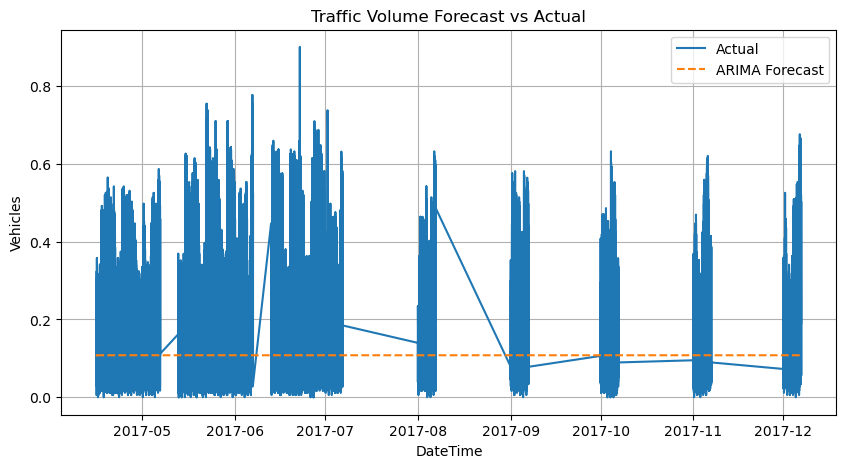

In [217]:
# Forecast for the same number of steps as your validation set
forecast = model_fit.forecast(steps=len(val))

# Plot actual vs forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(val.index, val['Vehicles'], label='Actual')
plt.plot(val.index, forecast, label='ARIMA Forecast', linestyle='--')
plt.title('Traffic Volume Forecast vs Actual')
plt.xlabel('DateTime')
plt.ylabel('Vehicles')
plt.legend()
plt.grid(True)
plt.show()


In [219]:
## 2 Gradient Boosting Trees (XGBoost)

MAE: 0.10, RMSE: 0.15, R²: -0.02


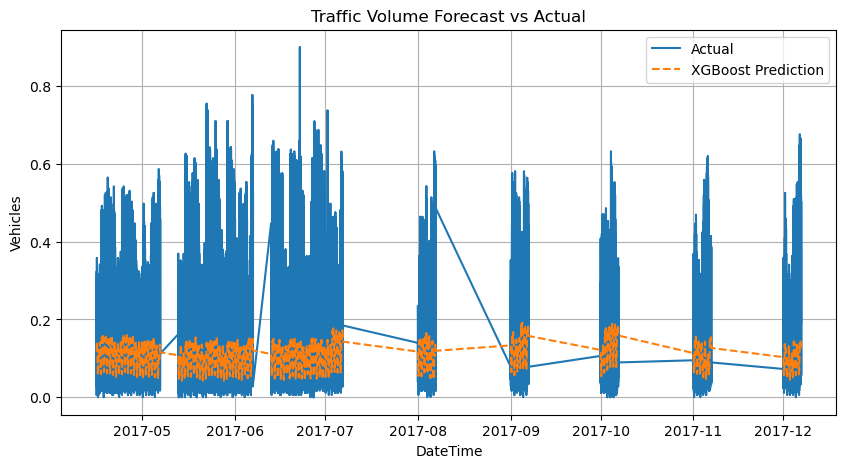

In [231]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Use only available features
features = ['hour', 'dayofweek', 'month']
target = 'Vehicles'

# Split features and target
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

# Initialize and train model
model_xgb = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
model_xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = model_xgb.predict(X_val)

# Evaluate
mae = mean_absolute_error(y_val, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
r2 = r2_score(y_val, y_pred_xgb)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(val.index, y_val.values, label='Actual')
plt.plot(val.index, y_pred_xgb, label='XGBoost Prediction', linestyle='--')
plt.title('Traffic Volume Forecast vs Actual')
plt.xlabel('DateTime')
plt.ylabel('Vehicles')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
# 2 lstm

In [19]:
!pip install tensorflow


In [21]:
#Load and Prepare Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load dataset
train = pd.read_csv('Final_Integrated_Dataset.csv')

# Use only the 'Vehicles' column for LSTM
df = train[['Vehicles']]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 24  # past 24 hours
X, y = create_sequences(scaled_data, seq_length)

# Split into train and validation sets
split = int(len(X) * 0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]


In [23]:
# Build and Compile LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Input

model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')


In [25]:
#Train the Model
history = model.fit(X_train, y_train,epochs=20, validation_data=(X_val, y_val), verbose=1) 

Epoch 1/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0087 - val_loss: 0.0196
Epoch 2/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0084 - val_loss: 0.0191
Epoch 3/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0084 - val_loss: 0.0198
Epoch 4/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0084 - val_loss: 0.0195
Epoch 5/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0083 - val_loss: 0.0189
Epoch 6/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0083 - val_loss: 0.0191
Epoch 7/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0083 - val_loss: 0.0190
Epoch 8/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 0.0082 - val_loss: 0.0188
Epoch 9/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 0.0081 - val_loss: 0.0183
Epoch 10/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0080 - val_loss: 0.0178
Epoch 11/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0078 - val_loss: 0.0176
Epoch 12/20
1

In [26]:
#Predict and Rescale
y_pred = model.predict(X_val)

# Rescale predictions and actual values
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1))


301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


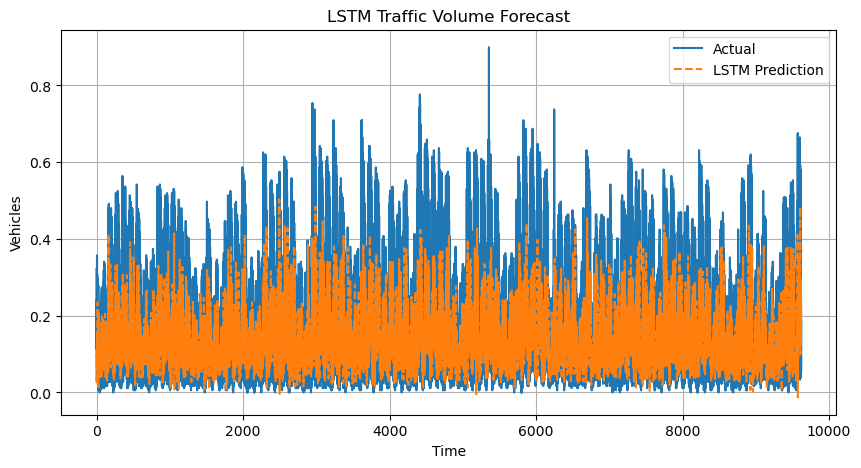

In [28]:
#Plot Results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_val_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='LSTM Prediction', linestyle='--')
plt.title('LSTM Traffic Volume Forecast')
plt.xlabel('Time')
plt.ylabel('Vehicles')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
#Evaluate Model

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_val_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_val_rescaled, y_pred_rescaled))
r2 = r2_score(y_val_rescaled, y_pred_rescaled)

print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}')


MAE: 0.10, RMSE: 0.13, R²: 0.23


In [34]:
#Time-Based Cross-Validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    model = Sequential()
    model.add(Input(shape=(X_train_fold.shape[1], X_train_fold.shape[2])))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_train_fold, y_train_fold, epochs=10, verbose=0)
    y_pred_fold = model.predict(X_test_fold)

    # Rescale and evaluate
    y_pred_fold_rescaled = scaler.inverse_transform(y_pred_fold)
    y_test_fold_rescaled = scaler.inverse_transform(y_test_fold.reshape(-1, 1))

    mae = mean_absolute_error(y_test_fold_rescaled, y_pred_fold_rescaled)
    rmse = np.sqrt(mean_squared_error(y_test_fold_rescaled, y_pred_fold_rescaled))
    r2 = r2_score(y_test_fold_rescaled, y_pred_fold_rescaled)

    print(f'Fold MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}')


251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Fold MAE: 0.05, RMSE: 0.07, R²: 0.21
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Fold MAE: 0.07, RMSE: 0.09, R²: 0.20
